<a href="https://colab.research.google.com/github/abhijain864/Project_Principal-Component-Analysis/blob/main/Olivetti_face_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. PCA

Now we will implement PCA. Assuming that we are performing PCA on
some dataset $\boldsymbol X$ for $M$ principal components. 
we need to perform the following steps, which we break into parts:

1. Data normalization (`normalize`).
2. Find eigenvalues and corresponding eigenvectors for the covariance matrix $S$.
   Sort by the largest eigenvalues and the corresponding eigenvectors (`eig`).

After these steps, we can then compute the projection and reconstruction of the data onto the spaced spanned by the top $n$ eigenvectors.

Data preprocessing-->

1. Subtract from each image the mean $\boldsymbol \mu$.
2. Scale each dimension of each image by $\frac{1}{\sigma}$ where $\sigma$ is the stardard deviation.

The steps above ensure that our images will have zero mean and one variance. These preprocessing
steps are also known as [Data Normalization or Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np

we will retrieve the Olivetti faces dataset.

In [3]:
from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people
from ipywidgets import interact
%matplotlib inline
image_shape = (64, 64)
# Load faces data
dataset = fetch_olivetti_faces('./')
faces = dataset.data

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to ./


We can find some invariants for projections. In the cell below, we have written two functions which check for invariants of projections. See the docstrings which explain what each of them does. You should use these functions to test your code.

In [4]:
import numpy.testing as np_test
def test_property_projection_matrix(P):
    """Test if the projection matrix satisfies certain properties.
    In particular, we should have P @ P = P, and P = P^T
    """
    np_test.assert_almost_equal(P, P @ P)
    np_test.assert_almost_equal(P, P.T)

def test_property_projection(x, p):
    """Test orthogonality of x and its projection p."""
    np_test.assert_almost_equal(p.T @ (p-x), 0)

## 1. Orthogonal Projections

For projection of a vector $\boldsymbol x$ onto a 1-dimensional subspace $U$ with basis vector $\boldsymbol b$ we have

$${\pi_U}(\boldsymbol x) = \frac{\boldsymbol b\boldsymbol b^T}{{\lVert\boldsymbol  b \rVert}^2}\boldsymbol x $$

And for the general projection onto an M-dimensional subspace $U$ with basis vectors $\boldsymbol b_1,\dotsc, \boldsymbol b_M$ we have

$${\pi_U}(\boldsymbol x) = \boldsymbol B(\boldsymbol B^T\boldsymbol B)^{-1}\boldsymbol B^T\boldsymbol x $$

where 

$$\boldsymbol B = [\boldsymbol b_1,...,\boldsymbol b_M]$$


To implement orthogonal projections, we have to
1. Find the projection matrix $\boldsymbol P$ that projects any $\boldsymbol x$ onto $U$.
2. The projected vector $\pi_U(\boldsymbol x)$ of $\boldsymbol x$ can then be written as $\pi_U(\boldsymbol x) = \boldsymbol P\boldsymbol x$.


In [5]:
# Projection 1d
def projection_matrix_1d(b):
    D, _ = b.shape
    ### compute a projection matrix of shape (D,D)  
    P = (np.dot(b,b.T)/np.sum(b*b))
    return P
def project_1d(x, b):
    p = np.dot(projection_matrix_1d(b),x) 
    return p

# Projection onto a general (higher-dimensional) subspace
def projection_matrix_general(B):
    P = B @ np.linalg.inv(B.T @ B) @ B.T 
    return P
def project_general(x, B):
    p = projection_matrix_general(B) @ x 
    return p

 some unittest to test the above implementation.

In [6]:
# Orthogonal projection in 2d
# define basis vector for subspace
b = np.array([2,1]).reshape(-1, 1)
# point to be projected later
x = np.array([1,2]).reshape(-1, 1)

In the next cell, we check that these invariants hold for the functions that we implemented earlier

In [7]:
# This whole section of np_test.assert can be removed if one wants to, this is for only checking that the prevoius functions are working or not


# Test 1D
# Test that we computed the correct projection matrix
np_test.assert_almost_equal(projection_matrix_1d(np.array([1, 2, 2]).reshape(-1,1)), 
                            np.array([[1,  2,  2],
                                      [2,  4,  4],
                                      [2,  4,  4]]) / 9)

# Test that we project x on to the 1d subspace correctly
np_test.assert_almost_equal(project_1d(np.ones((3,1)),
                                       np.array([1, 2, 2]).reshape(-1,1)),
                            np.array([5, 10, 10]).reshape(-1,1) / 9)

B = np.array([[1, 0],
              [1, 1],
              [1, 2]])

# Test 2D
# Test that we computed the correct projection matrix
np_test.assert_almost_equal(projection_matrix_general(B), 
                            np.array([[5,  2, -1],
                                      [2,  2,  2],
                                      [-1, 2,  5]]) / 6)

# Test that we project x on to the 2d subspace correctly
np_test.assert_almost_equal(project_general(np.array([6, 0, 0]).reshape(-1,1), B), 
                            np.array([5, 2, -1]).reshape(-1,1))

## 2. Eigenfaces

Next, we will take a look at what happens if we project some dataset consisting of human faces onto some basis we call
the `eigenfaces`.

importing the packages that we need.

In [8]:
from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people
from ipywidgets import interact
%matplotlib inline
image_shape = (64, 64)
# Load faces data
dataset = fetch_olivetti_faces('./')
faces = dataset.data

In [9]:
faces.shape

(400, 4096)

In [10]:
# for numerical reasons we normalize the dataset
mean = faces.mean(axis=0)
print('mean size is ',mean.size)
std = faces.std(axis=0)
print('std size is ',std.size)
faces_normalized = (faces - mean) / std

mean size is  4096
std size is  4096


#Let's visualize the dataset.

Text(0.5, 1.0, ' a random image from our dataset ')

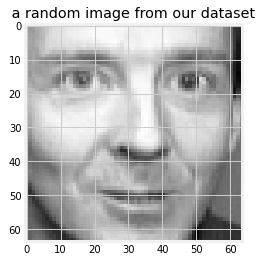

In [98]:
plt.imshow(faces[29].reshape(64,64),cmap='gray')
plt.title(' a random image from our dataset ')

In [12]:
array = np.zeros((20*64,20*64))
count= 0
for i in range(20):
  for j in range(20):
    array[i*64:(i+1)*64,j*64:(j+1)*64] = faces[count].reshape(64,64)
    count=count+1

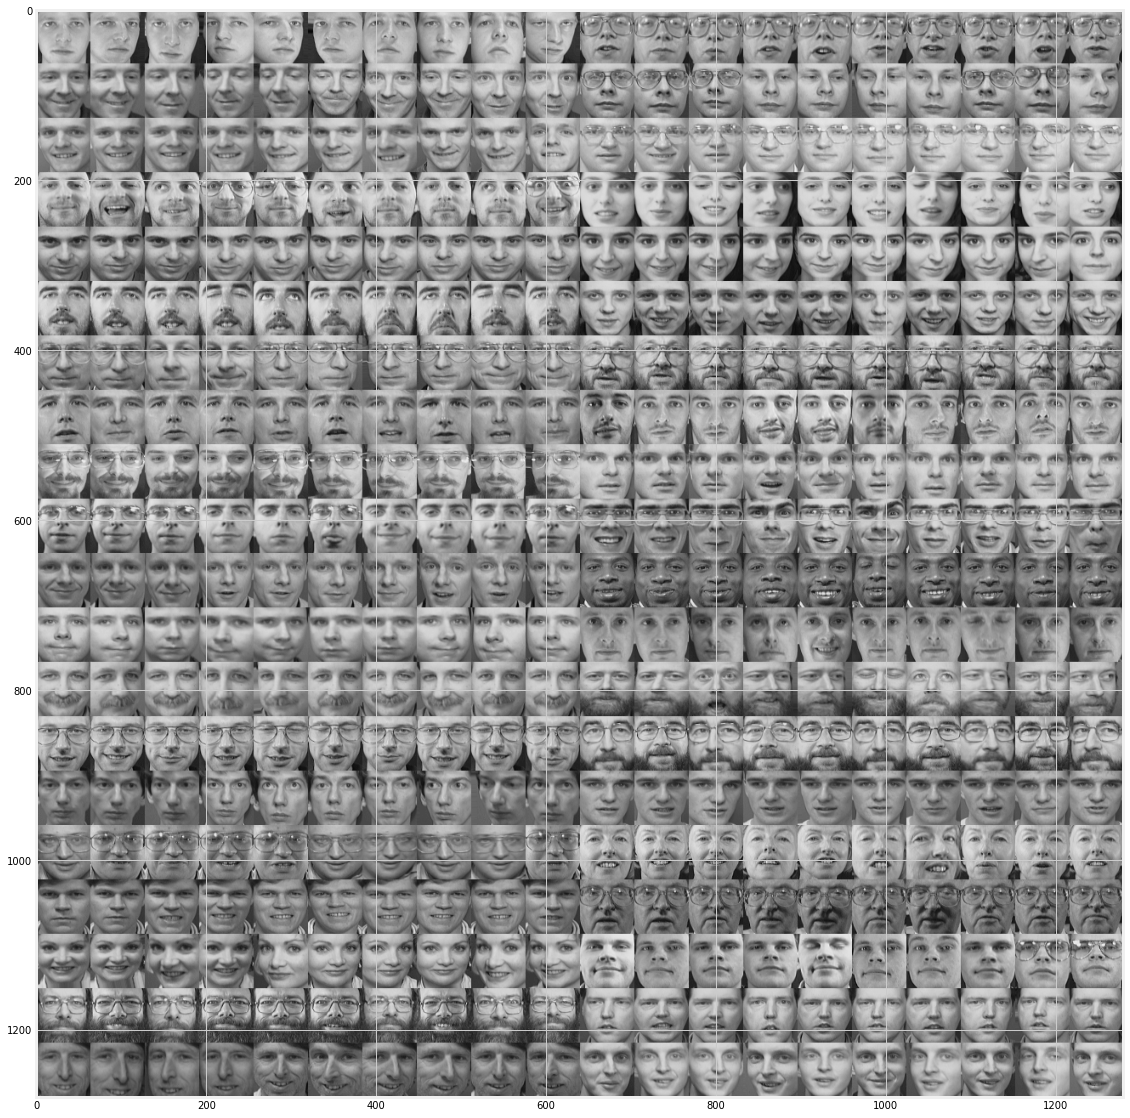

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(array,cmap='gray')

Let's take a set of 5 images

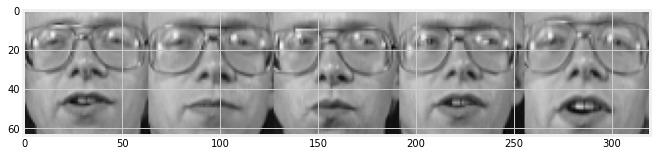

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(np.hstack(faces[10:15].reshape(5,64,64)), cmap='gray');

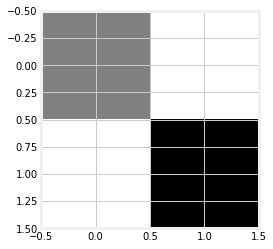

In [15]:
# Just for understanding  sake.

# For a grayscale images, the pixel value is a single number that represents the brightness of the pixel.
plt.imshow([[0.5,1],[1,0]],cmap='gray')

The data for the basis has been saved in a file named `eigenfaces.npy`, first we load it into the variable B.

In [17]:
def eig(S):
    (val, vec) = np.linalg.eig(S)
    vec = vec.T
    vec = vec[np.argsort(val)[::-1]]
    val = np.sort(val)[::-1]
    return (val,vec) #  returns the eigenvalues and corresponding eigenvectors, row wise sorted according by eigenvalue

In [18]:
# For this below example one eigenvalue is 8 and it's corresponding eigenvector is [2/3 , 1/3 , 2/3]
# Eigenvectors are returned as columns
np.linalg.eig(np.array([[3,2,4],[2,0,2],[4,2,3]]))

(array([-1.,  8., -1.]), array([[-0.74535599,  0.66666667, -0.20756326],
        [ 0.2981424 ,  0.33333333, -0.77602137],
        [ 0.59628479,  0.66666667,  0.59557394]]))

In [19]:
# Now this is in sorted order, on the basis of eigen value.
eig(np.array([[3,2,4],[2,0,2],[4,2,3]]))

(array([ 8., -1., -1.]), array([[ 0.66666667,  0.33333333,  0.66666667],
        [-0.20756326, -0.77602137,  0.59557394],
        [-0.74535599,  0.2981424 ,  0.59628479]]))

In [20]:
np.array([[1,2,3,4]]).reshape(-1,1)

array([[1],
       [2],
       [3],
       [4]])

In [21]:
np.array([[1,2,3],[4,5,6]])/np.array([[10],[20]])

array([[0.1 , 0.2 , 0.3 ],
       [0.2 , 0.25, 0.3 ]])

In [22]:
# We give the transpose of our (400,4096) dimensional dataset as input to X in the below_function.  
def basis_gen(X, n_components):
# X is (4096,400) dimensional, i.e. each column representing an image  
    cov_matrix = np.dot(X,X.T)
    val,vec = eig(cov_matrix)
    Basis = vec[:n_components].T # Basis is of dimension (4096,n_components) 

    return Basis  # <-return the reconstruction of X, B would be of shape(400,n_components) i.e 4096 dimesnionality reduced to n_components
                     # <-here 50, means that we have 
                     # Remember the dimensionality of data - (400,4096), 400 images each of 4096 dimension when flattened into a 1D vector.

In [50]:
num_comp = 4096 # number of components one wants to recover
basis  = basis_gen(faces_normalized.T,num_comp)
basis = basis.T
basis = basis.reshape(num_comp,64,64)

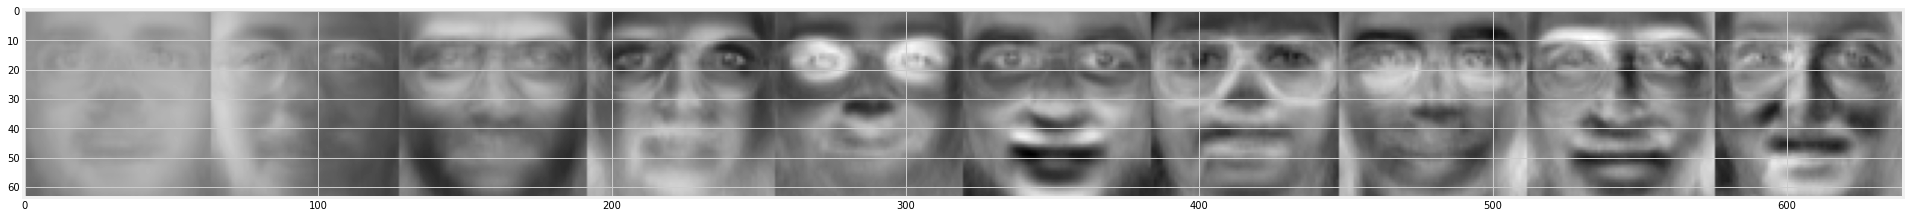

In [24]:
plt.figure(figsize=(30,30))
plt.imshow(np.hstack(basis[:10].reshape(-1, 64, 64)), cmap='gray');

Each instance in $\boldsymbol B$ is a `64x64' image, an "eigenface", which we determined using Principal Component Analysis. Let's visualize 
a few of those "eigenfaces".

Take a look at what happens if we project our faces onto the basis $\boldsymbol B$ spanned by these 50 "eigenfaces". In order to do this, we need to reshape $\boldsymbol B$ from above, which is of size (50, 64, 64), into the same shape as the matrix representing the basis as we have done earlier, which is of size (4096, 50). Here 4096 is the dimensionality of the data and 50 is the number of data points. 

Then we can reuse the functions we implemented earlier to compute the projection matrix and the projection. Now we visualize the reconstructed faces that lie on the subspace spanned by the "eigenfaces".

In [25]:
basis.shape

(100, 64, 64)

# Visualization of original vs reconstructed image

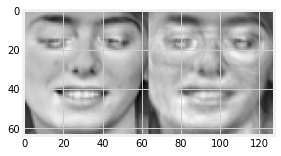

In [27]:
# EDIT THIS FUNCTION
@interact(i=(70, 76))
def show_face_face_reconstruction(i):
    without_normalized = faces[i].reshape(64,64)
    original_face = faces_normalized[i].reshape(64, 64)
    # reshape the data we loaded in variable `B` 
    # so that we have a matrix representing the basis.
    B = basis.reshape(100,4096).T
    #face_reconstruction = project_general(faces_normalized[i], B_basis).reshape(64, 64)
    face_reconstruction = (B @ B.T @ (faces_normalized[i].reshape(-1,1))).reshape(64,64) 
    plt.figure(figsize=(4,4))
    plt.imshow(np.hstack([original_face, face_reconstruction]), cmap='gray')
    plt.show()

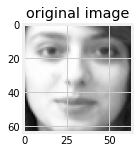

In [68]:
plt.figure(figsize=(2,2))
plt.title('original image')
plt.imshow(faces[71].reshape(64,64),cmap='gray')
# plt.imshow(faces_normalized[71].reshape(64,64),cmap='gray')

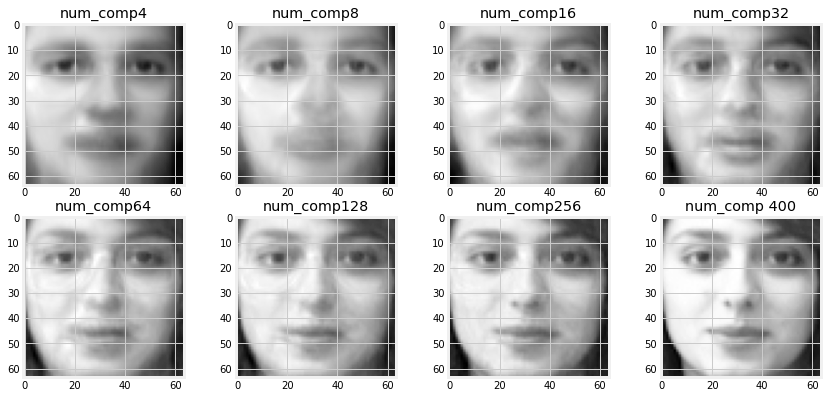

In [81]:
idx = 71
mean = faces.mean(axis=0)    ;  std = faces.std(axis=0)
mean = mean.reshape((64,64)) ;  std = std.reshape(64,64)
arr = np.zeros((1*64,1*64))
B = basis.reshape(-1,4096).T
array = np.zeros((1*64,1*64))
z = 2

fig = plt.figure(figsize=(13, 6.5))
columns = 4
rows = 2
for i in range(1, columns*rows +1):
    z = z*2
    ax = fig.add_subplot(rows, columns, i)
    if z==512:
      ax.set_title('num_comp 400')
    else:
      ax.set_title('num_comp{num}'.format(num=z))

    basis_matrix = B[:,:z]
    if z==512:
      basis_matrix = B[:,:400]
    # We take the first z columns of our Basis matrix i.e. z eigenvectors corresponding to the largest z eigenvalues
    face_reconstruction = (basis_matrix @ basis_matrix.T @ (faces_normalized[idx].reshape(-1,1))).reshape(64,64) 
    array = face_reconstruction*std + mean  #  unnormalize the reconstructed image 

    plt.imshow(array,cmap='gray')
plt.show()

# As the number of eigenvectors onto which we project our original images increases, the reconstruction i.e. the projection of any image onto the subspace spanned by those eigenvectors, resembles closer and closer to the original image, and becomes exactly equal to the original images, as soon as the number of eigenvectors = min(D,N), where in our ccase D(dimensionality of an image) = 4096, N(Number of data samples) = 400

In [82]:
def mse(predict, actual):
    """Helper function for computing the mean squared error (MSE)"""
    return np.square(predict - actual).sum(axis=1).mean()

In [92]:
loss = []
reconstructions = []
# iterate over different number of principal components, and compute the MSE
for num_component in range(1,410,10):
    basis_matrix = B[:,:num_component]
    # We take the first num_component columns of our Basis matrix i.e. z eigenvectors corresponding to the largest z eigenvalues
    reconst = (basis_matrix @ basis_matrix.T @ (faces_normalized).T).T
    error = mse(reconst, faces_normalized)
    # print('n = {:d}, reconstruction_error = {:f}'.format(num_component, error))
    loss.append((num_component, error))
loss = np.asarray(loss)

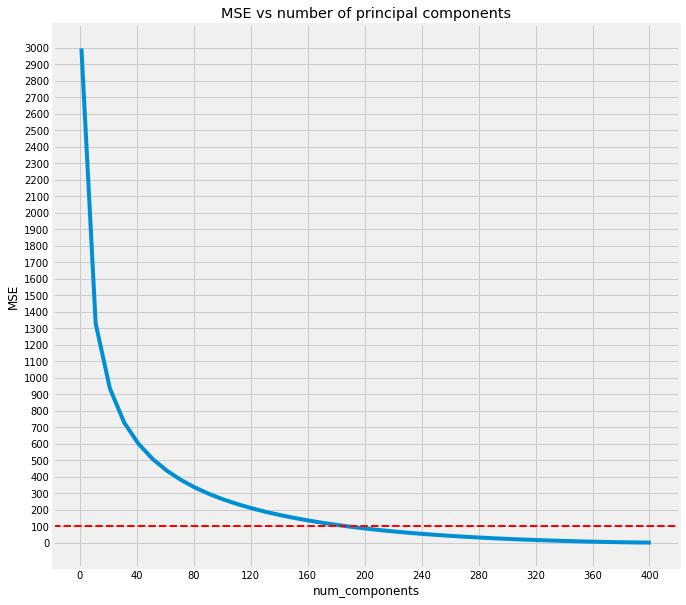

In [95]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(100, linestyle='--', color='r', linewidth=2)
ax.xaxis.set_ticks(np.arange(0, 420 , 40))
ax.yaxis.set_ticks(np.arange(0, 3001 , 100 ))
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

# It can be clearly seen both from the graph as well as the images, that when num_components reaches around 100-150, rate of decrease of MSE becomes quite slow, and there isn't much gain on increasing the num_of_components any further.
# At around num_components = 200, MSE becomes 1/30 of the initial MSE.
# At num_compnents = 400, MSE will exactly become 0
# Thus we have essentially reduced dimensionality approximately (4096/128) = 32 times